In [1]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [2]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('negative_images', '..\\dataset\\negative_images'),
 ('overlay', '..\\dataset\\overlay'),
 ('positive_images', '..\\dataset\\positive_images'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

Preparing a dataframe to summarize the dataset

In [3]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
256,negatives,50994191_cc9e66c5b31baab8_MG_R_CC_ANON.tif
78,positives,30011727_6968748e66837bc7_MG_L_ML_ANON.tif
60,positives,22678833_64a22c47765f0c5c_MG_R_ML_ANON.tif
19,positives,22427705_d713ef5849f98b6c_MG_L_CC_ANON.tif
207,negatives,24058660_9e8db9e34d5275ef_MG_R_CC_ANON.tif
366,negatives,53581237_80123a24997098dc_MG_R_ML_ANON.tif
378,negatives,53582395_3f0db31711fc9795_MG_L_ML_ANON.tif
122,negatives,20587690_f4b2d377f43ba0bd_MG_L_ML_ANON.tif
154,negatives,22613970_f23fa352e7de3dc7_MG_R_ML_ANON.tif
172,negatives,22670978_f571fd4e63c718e3_MG_L_CC_ANON.tif


Dataset Summary

In [4]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [5]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

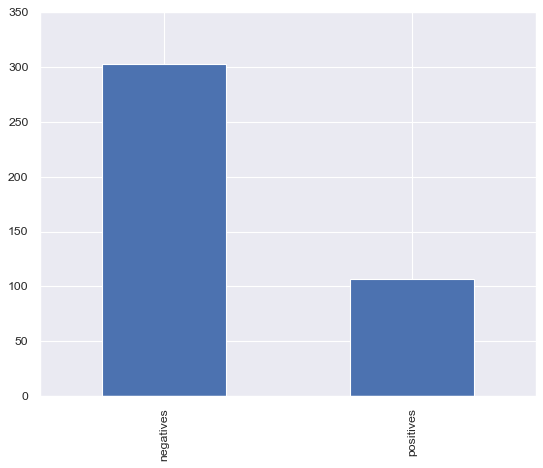

In [6]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

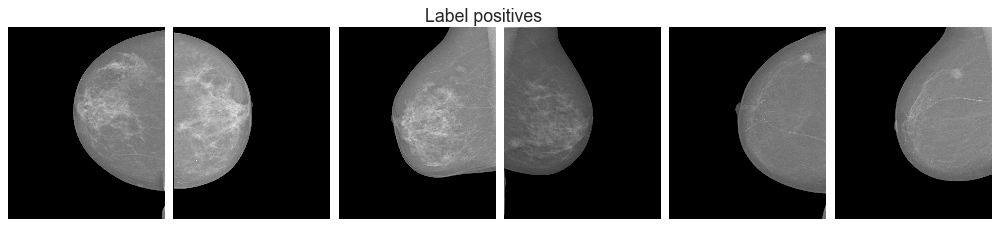

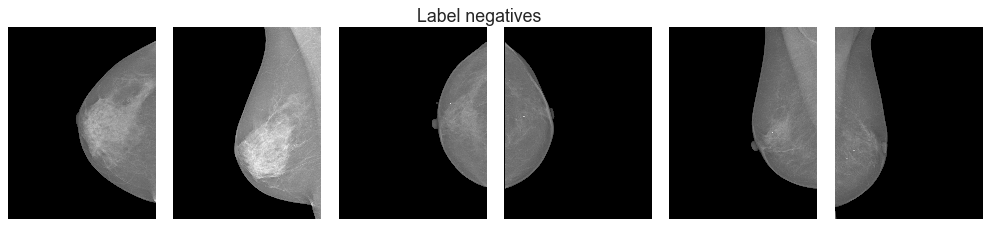

In [7]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

2023-05-10 09:48:27.189 | INFO     | preprocessing:fit:83 - Started processing pipeline.
100%|███████████████████████████| 1/1 [00:00<00:00,  3.32it/s]
2023-05-10 09:48:27.505 | INFO     | preprocessing:fit:128 - Finished processing 410 files in approximately 0.316 seconds.


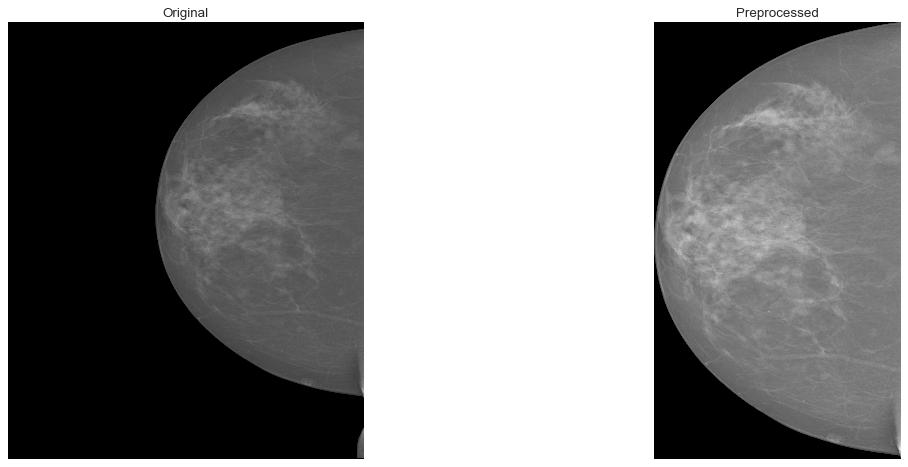

In [8]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], 
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

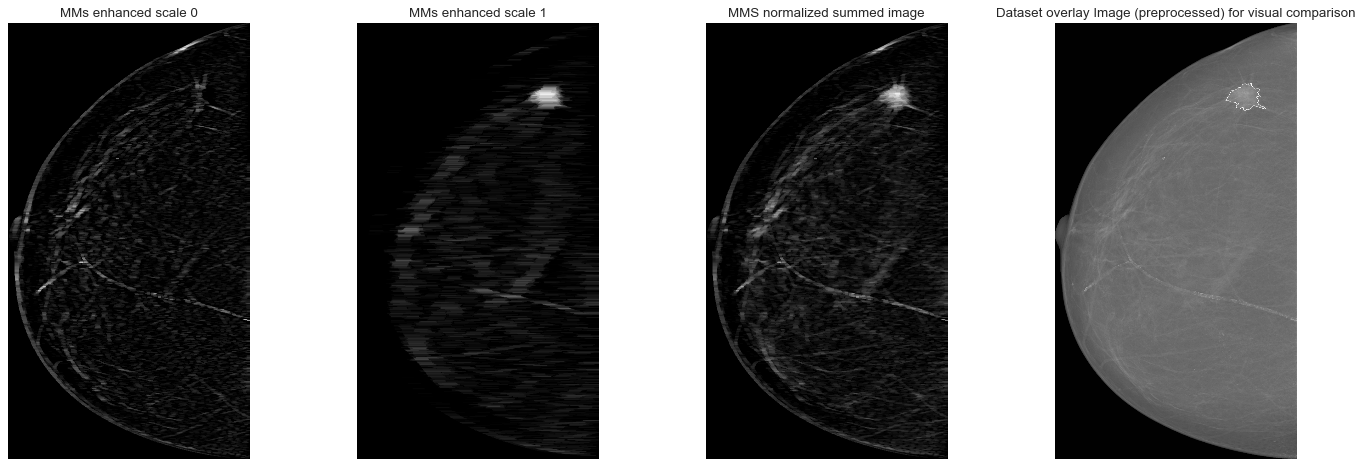

In [9]:
image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'
# image_input_name = '22670324_98429c0bdf78c0c7_MG_R_ML_ANON.tif'


normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
    image_input_name, 
    plot=False,
)

# Reading the same processed image (ovarlayed version) for visual comparison
overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
overlay_image = cv2.imread(overlay_image_dataset)

# Display the enhanced and tophat image
imgs = {
    "MMs enhanced scale 0": enhanced_images[0],
    "MMs enhanced scale 1": enhanced_images[1],
    "MMS normalized summed image": normalized_image,
    "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
}
display.plot_figures(imgs, 1, 4)

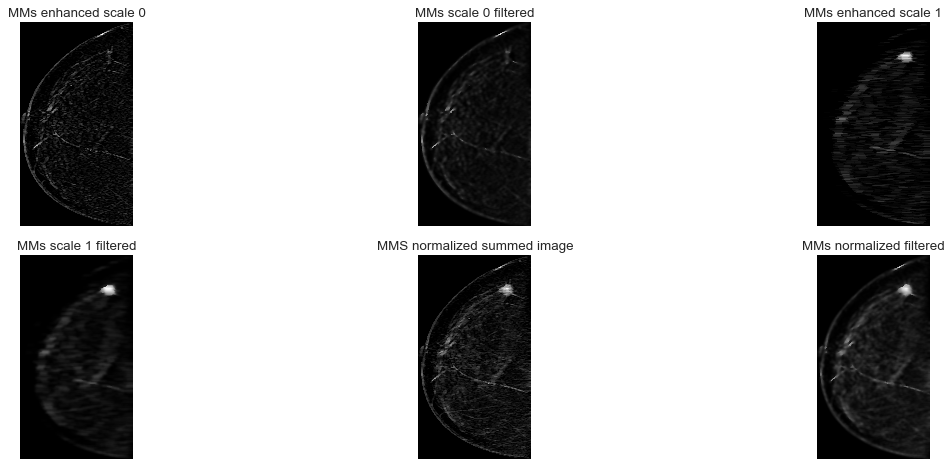

In [10]:
def mean_shift_filter(image, spatial_radius, range_radius):
    """
    Apply mean shift filter to a grayscale image.

    Parameters:
    - image: 2D numpy array of type uint16 with shape (height, width)
    - spatial_radius: int, spatial distance (in pixels) to consider for the filter
    - range_radius: int, color distance to consider for the filter

    Returns:
    - filtered_image: 2D numpy array of type uint16 with shape (height, width),
                      the result of the filter
    """

    # Convert image to float32 for better precision
    image_float = image.astype(np.float32)

    # Convert image to uint8 for OpenCV
    image_uint8 = cv2.convertScaleAbs(image_float / np.max(image_float) * 255)

    # Convert 2-channel grayscale image to 3-channel grayscale image
    image_3ch = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2BGR)

    # Apply mean shift filter using OpenCV
    filtered_image_uint8 = cv2.pyrMeanShiftFiltering(image_3ch, spatial_radius, range_radius)

    # Convert the filtered image back to uint16
    filtered_image_float = cv2.cvtColor(filtered_image_uint8, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0 * np.max(image_float)
    filtered_image = filtered_image_float.astype(np.uint16)

    return filtered_image


# Display the enhanced and tophat image
imgs = {
    "MMs enhanced scale 0": enhanced_images[0],
    "MMs scale 0 filtered": mean_shift_filter(enhanced_images[0], spatial_radius=5, range_radius=100),
    "MMs enhanced scale 1": enhanced_images[1],
    "MMs scale 1 filtered": mean_shift_filter(enhanced_images[1], spatial_radius=5, range_radius=100),
    "MMS normalized summed image": normalized_image,
    "MMs normalized filtered": mean_shift_filter(normalized_image, spatial_radius=5, range_radius=100)
#         "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
}
display.plot_figures(imgs, 2, 3)


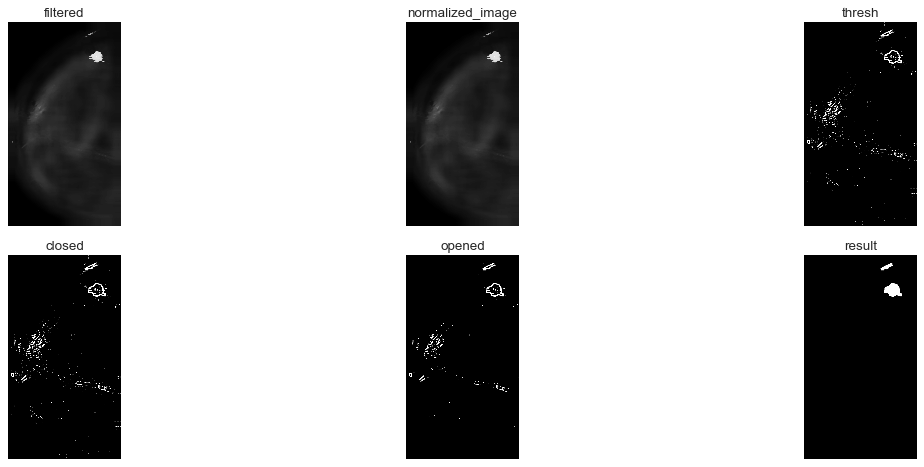

In [30]:
def multi_otsu_threshold(image, num_thresholds):
    # Convert the image to uint8 format
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    
    # Calculate the threshold values using multi-level Otsu
    thresholds = [0]
    for i in range(num_thresholds-1):
        t, _ = cv2.threshold(image_uint8, thresholds[-1], 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if t > thresholds[-1]:
            thresholds.append(t)
        else:
            break
    thresholds.append(255)
    
    # Apply the thresholds to the image
    thresholded_image = np.zeros_like(image)
    for i in range(len(thresholds)-1):
        mask = cv2.inRange(image_uint8, thresholds[i], thresholds[i+1])
        thresholded_image[mask > 0] = i+1
    
    return thresholded_image, thresholds


def triangle_threshold(image):
    # Convert the image to uint8
    image_uint8 = np.uint8((image / np.max(image)) * 255)

    # Calculate the histogram of the image
    hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 256])

    # Find the index of the maximum histogram peak
    max_peak_idx = np.argmax(hist)

    # Initialize the threshold value and minimum distance
    threshold = 0
    min_dist = np.inf

    # Iterate over all possible threshold values
    for t in range(256):
        # Calculate the foreground and background pixel intensities
        fg = hist[max_peak_idx:t]
        bg = hist[t:max_peak_idx]

        # Calculate the foreground and background probabilities
        fg_prob = np.sum(fg) / np.sum(hist)
        bg_prob = np.sum(bg) / np.sum(hist)

        # Calculate the foreground and background mean pixel intensities
        fg_mean = np.sum(np.arange(max_peak_idx, t) * fg) / np.sum(fg)
        bg_mean = np.sum(np.arange(t, max_peak_idx) * bg) / np.sum(bg)

        # Calculate the distance between the foreground and background means
        dist = fg_prob * bg_prob * (fg_mean - bg_mean)**2

        # Update the threshold if the distance is smaller than the current minimum
        if dist < min_dist:
            threshold = t
            min_dist = dist

    # Apply the threshold to the image and return the binary image
    return cv2.threshold(image_uint8, threshold, 255, cv2.THRESH_BINARY)[1]

def fillHoles(binary_image):
    # Create a rectangular structuring element with size 3x3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Dilate the binary image using the structuring element
    dilated = cv2.dilate(binary_image, kernel)

    # Erode the dilated image using the structuring element
    eroded = cv2.erode(dilated, kernel)

    # Invert the eroded image and AND it with the original binary image to fill in holes
    filled = cv2.bitwise_and(binary_image, cv2.bitwise_not(eroded))

    return filled

def circular_dilation_erosion(image, kernel_size, iterations):
    # Create a circular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Apply erosion
    eroded = cv2.erode(image, kernel, iterations=iterations)

    # Apply dilation
    dilated = cv2.dilate(eroded, kernel, iterations=iterations)
    
    return dilated

def eliminate_by_area(image, min_area, max_area):
    # Convert to uint8
    image = (image/np.max(image) * 255).astype(np.uint8)
    
    # Apply mean shift filtering to enhance tumor features
    filtered = mean_shift_filter(image, spatial_radius=30, range_radius=120)

    # Normalize the filtered image to improve contrast
    normalized_image = cv2.normalize(filtered, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#     # Apply thresholding
#     _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Perform adaptive thresholding on the normalized image
    thresh = cv2.adaptiveThreshold(normalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 2)

#     Perform morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Perform morphological opening to eliminate remaining small objects
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Find contours of thresholded image
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank image to draw contours on
    result = np.zeros_like(opened)

    # Loop through contours and eliminate those outside the desired area range
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area and area < max_area:
            cv2.drawContours(result, [cnt], 0, (255, 255, 255), -1)

    # Display the enhanced and tophat image
    imgs = {
#         "image": image,
        "filtered": filtered,
        "normalized_image":normalized_image,
        "thresh":thresh,
        "closed": closed,
        "opened": opened,
        "result": result
    }
    display.plot_figures(imgs, 2, 3)

    return result


image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'
# image_input_name = '53586869_6ac23356b912ee9b_MG_L_ML_ANON.tif'
# image_input_name = '22670324_98429c0bdf78c0c7_MG_R_ML_ANON.tif'

normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
    image_input_name, 
    plot=False,
)


# Find the average min and max area of mass sizes from the ground truth, calculate pixel wise and update the function call 
mass = eliminate_by_area(normalized_image, min_area=500, max_area=3689) 





# Display the enhanced and tophat image
imgs = {
    "MMS normalized summed image": normalized_image,
    "mass":mass
}
# display.plot_figures(imgs, 1, 2)

In [10]:


# Instead of MLO Thresholding
# superpixels - non-parametric approach
# k means clusturing - K levels
# means clusturing - reguarization params


# Features extraction
# GLCM features 10-15 + statistics of mass region (contrast average value)

# Shape features 10
# LBP 
# SIFTs

# Gabor wavelets ~ good to charectirize textures in iris


# Features reduction - LDA 

In [11]:
# Set the paths to the positive images and groundtruth folders
positive_images_path = '../dataset/positive_images'
groundtruth_path = '../dataset/groundtruth'

# Get a list of all the tif images in the positive images folder
tif_images = [f for f in os.listdir(positive_images_path) if f.endswith('.tif')]

In [12]:
tif_images

['20586908_6c613a14b80a8591_MG_R_CC_ANON.tif',
 '20586934_6c613a14b80a8591_MG_L_CC_ANON.tif',
 '20586960_6c613a14b80a8591_MG_R_ML_ANON.tif',
 '20586986_6c613a14b80a8591_MG_L_ML_ANON.tif',
 '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif',
 '20587664_f4b2d377f43ba0bd_MG_R_ML_ANON.tif',
 '20587758_81cd83d2f4d78528_MG_L_CC_ANON.tif',
 '20587810_81cd83d2f4d78528_MG_L_ML_ANON.tif',
 '20587902_8dbbd4e51f549ff0_MG_R_CC_ANON.tif',
 '20587928_8dbbd4e51f549ff0_MG_R_ML_ANON.tif',
 '20587994_024ee3569b2605dc_MG_R_CC_ANON.tif',
 '20588046_024ee3569b2605dc_MG_R_ML_ANON.tif',
 '20588190_8d0b9620c53c0268_MG_L_CC_ANON.tif',
 '20588216_8d0b9620c53c0268_MG_L_ML_ANON.tif',
 '20588308_493155e17143edef_MG_L_ML_ANON.tif',
 '20588334_493155e17143edef_MG_L_CC_ANON.tif',
 '20588536_bf1a6aaadb05e3df_MG_L_ML_ANON.tif',
 '20588562_bf1a6aaadb05e3df_MG_L_CC_ANON.tif',
 '20588680_036aff49b8ac84f0_MG_L_ML_ANON.tif',
 '22427705_d713ef5849f98b6c_MG_L_CC_ANON.tif',
 '22427751_d713ef5849f98b6c_MG_L_ML_ANON.tif',
 '22427840_bb

In [15]:
def mean_shift_filter(image, spatial_radius=40, color_radius=80):
    # Normalize the image to the range [0, 255]
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Convert the image to BGR color space
    bgr_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
    
    # Apply mean shift filtering
    filtered_image = cv2.pyrMeanShiftFiltering(bgr_image, spatial_radius, color_radius)
    
    # Convert the filtered image to grayscale
    grayscale_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    
    return grayscale_image

In [ ]:
plt.rcParams['figure.max_open_warning'] = False

for image_input_name in tif_images:

    normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
        image_input_name, 
        plot=False,
    )

    # Reading the same processed image (ovarlayed version) for visual comparison
    overlay_image_dataset = os.path.join(mms.overlay_dir, image_input_name)
    overlay_image = cv2.imread(overlay_image_dataset)

    # Display the enhanced and tophat image
    imgs = {
        "MMs enhanced scale 0": enhanced_images[0],
        "MMs scale 0 filtered": mean_shift_filter(enhanced_images[0]),
        "MMs enhanced scale 1": enhanced_images[1],
        "MMs scale 1 filtered": mean_shift_filter(enhanced_images[1]),
        "MMS normalized summed image": normalized_image,
        "MMs scale 0 filtered": mean_shift_filter(normalized_image)
#         "Dataset overlay Image (preprocessed) for visual comparison": overlay_image
    }
    display.plot_figures(imgs, 2, 3)